<a href="https://colab.research.google.com/github/volfenstein1/dida_segmentation_task/blob/main/2_dida_segmentation_task_iteration_and_experimentation_static2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iteration and Experimentation

This notebook contains my process of systematic iteration and experimentation.

In [ ]:
# @title
%%capture

print('Install packages, python imports, load the data from Google Drive, create the dataset')
# Install packages
!pip install torchvision;
!pip install segmentation-models-pytorch;
!pip install albumentationsx;

# Imports
from google.colab import drive
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss, SoftBCEWithLogitsLoss, SoftCrossEntropyLoss, JaccardLoss, TverskyLoss, LovaszLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, f1_score
import albumentations as A

# Load the data from google drive
drive.mount("/mnt/drive")

images_path = "/mnt/drive/MyDrive/dida/images"
labels_path = "/mnt/drive/MyDrive/dida/labels"
to_predict = "/mnt/drive/MyDrive/dida/to_predict"

# Create the DataSet
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.common_filenames = sorted(f for f in os.listdir(image_dir) if f in os.listdir(label_dir))

    def __len__(self):
        return len(self.common_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.common_filenames[idx])
        label_path = os.path.join(self.label_dir, self.common_filenames[idx])

        image_pil = Image.open(image_path)
        label_pil = Image.open(label_path)

        image_tensor = ToTensor()(image_pil)
        label_tensor = ToTensor()(label_pil)

        return image_tensor, label_tensor

ds = SegmentationDataset(images_path, labels_path)

train_size = 20
val_size = 4
train_dataset, val_dataset = torch.utils.data.random_split(ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

The following function encapsulates some of the choices we could make for our model.

It accepts as parameters:
- number of epochs: The number of epochs to train for. During testing, I kept this set to 250.
- patience: An optional parameter for early stopping if the F1 score does not improve. I created this since in early experiments, the F1 score would start to decrease as the model appeared to overfit. A default value of zero ignores this setting.
- model architecture: The model architecture, https://smp.readthedocs.io/en/latest/models.html.
- model encoder: The model encoder, https://smp.readthedocs.io/en/latest/encoders.html.
- encoder weights: Pretrained encoder weights, https://smp.readthedocs.io/en/latest/encoders.html.
- optimizer: The optimizer, https://docs.pytorch.org/docs/stable/optim.html.
- learning rate: The learning rate.
- loss function: The loss function for the segmentation task, imported from the SMP library https://smp.readthedocs.io/en/latest/losses.html.
- verbose (true/false): A setting for whether to print metrics every 10 epochs or not.

It returns the full training / validation records of several [loss functions](https://smp.readthedocs.io/en/latest/losses.html) and [metrics](https://smp.readthedocs.io/en/latest/metrics.html):

- The losses for the selected loss function. (lower is better)
- The Dice score. (higher is better)
- The Focal score. (lower is better)
- The Binary Cross Entropy score. (lower is better)
- The model accuracy. (higher is better)
- The model F1 score. (higher is better)

In [ ]:
# @title
print('Define the train_model function, which takes as input model choices and returns full training / validation records of various metrics')
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_model(num_epochs, patience, model_name, encoder_name, encoder_weights, optimizer_type, lr, loss_function_type, verbose=False):
    # Define the model
    if model_name == "Unet":
        model = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "UnetPlusPlus":
        model = smp.UnetPlusPlus(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "FPN":
        model = smp.FPN(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "PSPNet":
        model = smp.PSPNet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "DeepLabV3":
        model = smp.DeepLabV3(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "DeepLabV3Plus":
        model = smp.DeepLabV3Plus(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "Linknet":
        model = smp.Linknet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "MAnet":
        model = smp.MAnet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "PAN":
        model = smp.PAN(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "UPerNet":
        model = smp.UPerNet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "Segformer":
        model = smp.Segformer(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    elif model_name == "DPT":
        model = smp.DPT(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=4, classes=1, activation='sigmoid')
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Move the model to the device
    model.to(device)

    # Define the optimizer
    if optimizer_type == "Adadelta":
        optimizer = optim.Adadelta(model.parameters(), lr=lr)
    elif optimizer_type == "Adafactor":
        optimizer = optim.Adafactor(model.parameters(), lr=lr)
    elif optimizer_type == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=lr)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif optimizer_type == 'Adamax':
        optimizer = optim.Adamax(model.parameters(), lr=lr)
    elif optimizer_type == 'ASGD':
        optimizer = optim.ASGD(model.parameters(), lr=lr)
    elif optimizer_type == 'NAdam':
        optimizer = optim.NAdam(model.parameters(), lr=lr)
    elif optimizer_type == 'RAdam':
        optimizer = optim.RAdam(model.parameters(), lr=lr)
    elif optimizer_type == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_type == 'Rprop':
        optimizer = optim.Rprop(model.parameters(), lr=lr)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

    # Define the loss function
    if loss_function_type == 'FocalLoss':
        loss_function = FocalLoss(mode="binary")
    elif loss_function_type == 'DiceLoss':
        loss_function = DiceLoss(mode="binary")
    elif loss_function_type == 'LogDiceLoss':
        loss_function = DiceLoss(mode="binary", log_loss=True)
    elif loss_function_type == 'SoftBCEWithLogitsLoss':
        loss_function = SoftBCEWithLogitsLoss()
    elif loss_function_type == 'IOULoss':
        loss_function = JaccardLoss(mode="binary")
    elif loss_function_type == 'TverskyLoss':
        loss_function = TverskyLoss(mode="binary")
    elif loss_function_type == "LovaszLoss":
        loss_function = LovaszLoss(mode="binary")
    elif loss_function_type == 'CombinedLoss':
        bce_loss = SoftBCEWithLogitsLoss()
        log_dice_loss = DiceLoss(mode="binary", log_loss=True)
        loss_function = lambda outputs, labels: bce_loss(outputs, labels) + log_dice_loss(outputs, labels)
    else:
        raise ValueError(f"Unsupported loss function type: {loss_function_type}")

    print("-" * 50)
    print(f"Training with Model Architecture: {model_name}, Encoder: {encoder_name}, Weight: {encoder_weights}, Optimizer: {optimizer_type}, LR: {lr}, Loss Function: {loss_function_type}")

    # Early stopping parameters based on F1
    best_val_f1 = float('-inf')
    epochs_no_improve = 0

    train_losses = []
    train_dices = []
    train_focals = []
    train_bce = []
    train_accuracies = []
    train_f1_scores = []

    val_losses = []
    val_dices = []
    val_focals = []
    val_bce = []
    val_accuracies = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()

        running_loss = 0.0
        running_dice = 0.0
        running_focal = 0.0
        running_bce = 0.0
        running_accuracy = 0.0
        running_f1 = 0.0

        for i, (images, labels) in enumerate(train_loader):
            # Move data to the device
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = loss_function(outputs, labels)

            # Calculate other metrics (assuming these are still desired)
            # These metrics are independent of the chosen main loss function
            batch_dice = 1.0 - DiceLoss(mode="binary")(outputs, labels)
            batch_focal = FocalLoss(mode="binary")(outputs, labels)
            batch_bce = SoftBCEWithLogitsLoss()(outputs, labels)

            labels_long = labels.long()
            tp, fp, fn, tn = get_stats(outputs, labels_long, mode="binary", threshold=0.5)
            batch_accuracy = accuracy(tp, fp, fn, tn).mean()
            batch_f1 = f1_score(tp, fp, fn, tn).mean()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running metrics
            running_loss += loss.item()
            running_focal += batch_focal.item()
            running_bce += batch_bce.item()
            running_dice += batch_dice.item()
            running_accuracy += batch_accuracy.item()
            running_f1 += batch_f1.item()


        train_losses.append(running_loss / len(train_loader))
        train_focals.append(running_focal / len(train_loader))
        train_bce.append(running_bce / len(train_loader))
        train_dices.append(running_dice / len(train_loader))
        train_accuracies.append(running_accuracy / len(train_loader))
        train_f1_scores.append(running_f1 / len(train_loader))


        # Print metrics
        if verbose and (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] finished. Training Loss: {train_losses[-1]:.4f}, Training Dice: {train_dices[-1]:.4f}, Training Focals: {train_focals[-1]:.4f}, Training BCE: {train_bce[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}, Training F1: {train_f1_scores[-1]:.4f}')

        # Evaluation loop after each epoch
        # Set the model to evaluation mode
        model.eval()
        validation_loss = 0.0
        validation_dice = 0.0
        validation_focal = 0.0
        validation_bce = 0.0
        validation_accuracy = 0.0
        validation_f1 = 0.0


        # Disable gradient calculation for evaluation
        with torch.no_grad():
            for images, labels in val_loader:
                # Move data to the device
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate the loss
                loss = loss_function(outputs, labels)

                # Calculate other metrics
                batch_dice = 1.0 - DiceLoss(mode="binary")(outputs, labels)
                batch_focal = FocalLoss(mode="binary")(outputs, labels)
                batch_bce = SoftBCEWithLogitsLoss()(outputs, labels)

                labels_long = labels.long()
                tp, fp, fn, tn = get_stats(outputs, labels_long, mode="binary", threshold=0.5)
                batch_accuracy = accuracy(tp, fp, fn, tn).mean()
                batch_f1 = f1_score(tp, fp, fn, tn).mean()

                # Update running metrics
                validation_loss += loss.item()
                validation_dice += batch_dice.item()
                validation_focal += batch_focal.item()
                validation_bce += batch_bce.item()
                validation_accuracy += batch_accuracy.item()
                validation_f1 += batch_f1.item()

        average_validation_loss = validation_loss / len(val_loader)
        average_validation_dice = validation_dice / len(val_loader)
        average_validation_focal = validation_focal / len(val_loader)
        average_validation_bce = validation_bce / len(val_loader)
        average_validation_accuracy = validation_accuracy / len(val_loader)
        average_validation_f1 = validation_f1 / len(val_loader)

        val_losses.append(average_validation_loss)
        val_dices.append(average_validation_dice)
        val_focals.append(average_validation_focal)
        val_bce.append(average_validation_bce)
        val_accuracies.append(average_validation_accuracy)
        val_f1_scores.append(average_validation_f1)


        # Print metrics
        if verbose and (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] finished. Validation Loss: {val_losses[-1]:.4f}, Validation Dice: {val_dices[-1]:.4f}, Validation Focal: {val_focals[-1]:.4f}, Validation BCE: {val_bce[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}, Validation F1: {val_f1_scores[-1]:.4f}')


        if patience != 0:
            # Early stopping check
            if average_validation_f1 > best_val_f1:
                best_val_f1 = average_validation_f1
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping after {epoch+1} epochs.')
                    break # Stop training loop


    print('Finished Training')
    print(f'Training Loss:   {train_losses[-1]:.4f}, Training Dice:   {train_dices[-1]:.4f}, Training Focals:   {train_focals[-1]:.4f}, Training BCE:   {train_bce[-1]:.4f}, Training Accuracy:   {train_accuracies[-1]:.4f}, Training F1:   {train_f1_scores[-1]:.4f}')
    print(f'Validation Loss: {val_losses[-1]:.4f}, Validation Dice: {val_dices[-1]:.4f}, Validation Focals: {val_focals[-1]:.4f}, Validation BCE: {val_bce[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}, Validation F1: {val_f1_scores[-1]:.4f}')

    # Return the trained model and metrics
    return model, train_losses, train_dices, train_focals, train_bce, train_accuracies, train_f1_scores, val_losses, val_dices, val_focals, val_bce, val_accuracies, val_f1_scores

Define the train_model function, which takes as input model choices and returns full training / validation records of various metrics
Using device: cuda


I define a helper function for plotting the various metrics. It takes as input a user selection of the model training data. In doing so, the plots for different choices can be visually inspected and analyzed.

In [ ]:
# @title
print('Define the plot selected function, for plotting metrics')
def plot_selected(results, selected, plot_loss=True):
    if plot_loss:
        metrics = [['train_losses', 'val_losses'], ['train_dices', 'val_dices'], ['train_focals', 'val_focals'], ['train_bce', 'val_bce'], ['train_accuracies', 'val_accuracies'], ['train_f1_scores', 'val_f1_scores']]
    else:
        metrics = [['train_dices', 'val_dices'], ['train_focals', 'val_focals'], ['train_bce', 'val_bce'], ['train_accuracies', 'val_accuracies'], ['train_f1_scores', 'val_f1_scores']]
    for train_val_pair in metrics:
        plt.figure(figsize=(8, 4))
        for metric in train_val_pair:
            for combination in selected:
                plt.plot(results[combination][metric], label=f'{combination} - {metric.replace("_", " ").title()}')
        plt.xlabel("epoch")
        plt.ylabel("metric value")
        plt.title("metric")
        plt.legend()
        plt.grid(True)
        plt.show()

Define the plot selected function, for plotting metrics


# Encoder and Weights

I begin by training and testing a selection of model encoders and pretrained weights.

I then plot the results interactively. By pressing 'Control+LeftClick' you can select multiple encoder/weight combinations to visibly compare.

In [ ]:
# @title
encoder_weight_results = {}

encoder_weight_pairs = [
    ("resnet34", "imagenet"),
    ("resnet152", "imagenet"),
    ("resnext101_32x8d", "imagenet"),
    ("dpn107", "imagenet+5k"),
    ("dpn131", "imagenet"),
    ("vgg19", "imagenet"),
    ("vgg19_bn", "imagenet"),
    ("senet154", "imagenet"),
    ("inceptionresnetv2", "imagenet"),
    ("inceptionresnetv2", "imagenet+background"),
    ("efficientnet-b7", "imagenet"),
    ("efficientnet-b7", "advprop"),
    ("timm-efficientnet-b8", "imagenet"),
    ("timm-efficientnet-b8", "advprop"),
    ("mit_b5", "imagenet"),
]

for encoder, weight in encoder_weight_pairs:
        model, train_losses, train_dices, train_focals, train_bce, train_accuracies, train_f1_scores, val_losses, val_dices, val_focals, val_bce, val_accuracies, val_f1_scores = train_model(
            num_epochs=200,
            patience=0,
            model_name="Unet",
            encoder_name=encoder,
            encoder_weights=weight,
            optimizer_type="Adam",
            lr=1e-4,
            loss_function_type="DiceLoss"
        )
        encoder_weight_results[f'{encoder}_{weight}'] = {
            'train_losses': train_losses,
            'train_dices': train_dices,
            'train_focals': train_focals,
            'train_bce': train_bce,
            'train_accuracies': train_accuracies,
            'train_f1_scores': train_f1_scores,
            'val_losses': val_losses,
            'val_dices': val_dices,
            'val_focals': val_focals,
            'val_bce': val_bce,
            'val_accuracies': val_accuracies,
            'val_f1_scores': val_f1_scores
        }

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: resnet34, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6949, Training Dice:   0.3051, Training Focals:   0.1731, Training BCE:   0.6743, Training Accuracy:   0.9725, Training F1:   0.8962
Validation Loss: 0.7662, Validation Dice: 0.2338, Validation Focals: 0.2121, Validation BCE: 0.7431, Validation Accuracy: 0.8703, Validation F1: 0.3334


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: resnet152, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.7011, Training Dice:   0.2989, Training Focals:   0.1936, Training BCE:   0.7055, Training Accuracy:   0.9689, Training F1:   0.8848
Validation Loss: 0.7492, Validation Dice: 0.2508, Validation Focals: 0.2123, Validation BCE: 0.7412, Validation Accuracy: 0.9180, Validation F1: 0.6133


config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: resnext101_32x8d, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.7045, Training Dice:   0.2955, Training Focals:   0.2065, Training BCE:   0.7237, Training Accuracy:   0.9632, Training F1:   0.8664
Validation Loss: 0.7644, Validation Dice: 0.2356, Validation Focals: 0.2115, Validation BCE: 0.7472, Validation Accuracy: 0.9078, Validation F1: 0.3240


config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: dpn107, Weight: imagenet+5k, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6939, Training Dice:   0.3061, Training Focals:   0.1670, Training BCE:   0.6651, Training Accuracy:   0.9735, Training F1:   0.9000
Validation Loss: 0.7457, Validation Dice: 0.2543, Validation Focals: 0.1905, Validation BCE: 0.7062, Validation Accuracy: 0.9087, Validation F1: 0.5806


config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/318M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: dpn131, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.7044, Training Dice:   0.2956, Training Focals:   0.2070, Training BCE:   0.7231, Training Accuracy:   0.9537, Training F1:   0.8392
Validation Loss: 0.7524, Validation Dice: 0.2476, Validation Focals: 0.2041, Validation BCE: 0.7312, Validation Accuracy: 0.9216, Validation F1: 0.5775


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/575M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: vgg19, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6975, Training Dice:   0.3025, Training Focals:   0.1814, Training BCE:   0.6871, Training Accuracy:   0.9710, Training F1:   0.8913
Validation Loss: 0.7465, Validation Dice: 0.2535, Validation Focals: 0.2013, Validation BCE: 0.7244, Validation Accuracy: 0.9242, Validation F1: 0.6410


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/575M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: vgg19_bn, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6969, Training Dice:   0.3031, Training Focals:   0.1799, Training BCE:   0.6849, Training Accuracy:   0.9726, Training F1:   0.8967
Validation Loss: 0.7727, Validation Dice: 0.2273, Validation Focals: 0.2121, Validation BCE: 0.7458, Validation Accuracy: 0.8680, Validation F1: 0.2328


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/461M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: senet154, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6994, Training Dice:   0.3006, Training Focals:   0.1877, Training BCE:   0.6964, Training Accuracy:   0.9687, Training F1:   0.8844
Validation Loss: 0.7399, Validation Dice: 0.2601, Validation Focals: 0.2043, Validation BCE: 0.7284, Validation Accuracy: 0.9496, Validation F1: 0.7647


config.json:   0%|          | 0.00/144 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: inceptionresnetv2, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6926, Training Dice:   0.3074, Training Focals:   0.1667, Training BCE:   0.6641, Training Accuracy:   0.9738, Training F1:   0.9011
Validation Loss: 0.7536, Validation Dice: 0.2464, Validation Focals: 0.1894, Validation BCE: 0.7087, Validation Accuracy: 0.9095, Validation F1: 0.5153


config.json:   0%|          | 0.00/144 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: inceptionresnetv2, Weight: imagenet+background, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6953, Training Dice:   0.3047, Training Focals:   0.1754, Training BCE:   0.6777, Training Accuracy:   0.9728, Training F1:   0.8976
Validation Loss: 0.7598, Validation Dice: 0.2402, Validation Focals: 0.1946, Validation BCE: 0.7205, Validation Accuracy: 0.9157, Validation F1: 0.4750


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: efficientnet-b7, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.7010, Training Dice:   0.2990, Training Focals:   0.1924, Training BCE:   0.7029, Training Accuracy:   0.9604, Training F1:   0.8579
Validation Loss: 0.7327, Validation Dice: 0.2673, Validation Focals: 0.2414, Validation BCE: 0.7700, Validation Accuracy: 0.8703, Validation F1: 0.6139


config.json:   0%|          | 0.00/94.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: efficientnet-b7, Weight: advprop, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.7003, Training Dice:   0.2997, Training Focals:   0.1913, Training BCE:   0.7013, Training Accuracy:   0.9623, Training F1:   0.8635
Validation Loss: 0.7266, Validation Dice: 0.2734, Validation Focals: 0.2184, Validation BCE: 0.7396, Validation Accuracy: 0.9180, Validation F1: 0.7194


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: timm-efficientnet-b8, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6999, Training Dice:   0.3001, Training Focals:   0.1899, Training BCE:   0.6992, Training Accuracy:   0.9640, Training F1:   0.8691
Validation Loss: 0.7318, Validation Dice: 0.2682, Validation Focals: 0.1967, Validation BCE: 0.7148, Validation Accuracy: 0.9556, Validation F1: 0.8039


config.json:   0%|          | 0.00/94.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: timm-efficientnet-b8, Weight: advprop, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6991, Training Dice:   0.3009, Training Focals:   0.1850, Training BCE:   0.6923, Training Accuracy:   0.9663, Training F1:   0.8764
Validation Loss: 0.7304, Validation Dice: 0.2696, Validation Focals: 0.1900, Validation BCE: 0.7053, Validation Accuracy: 0.9623, Validation F1: 0.8295


config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: mit_b5, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6931, Training Dice:   0.3069, Training Focals:   0.1688, Training BCE:   0.6669, Training Accuracy:   0.9697, Training F1:   0.8875
Validation Loss: 0.7321, Validation Dice: 0.2679, Validation Focals: 0.1763, Validation BCE: 0.6850, Validation Accuracy: 0.9560, Validation F1: 0.7970


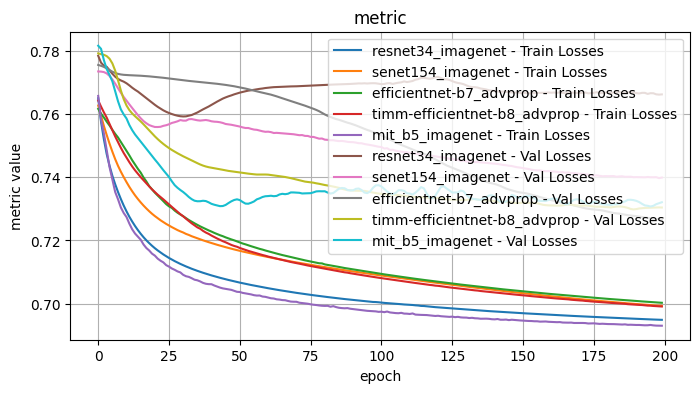

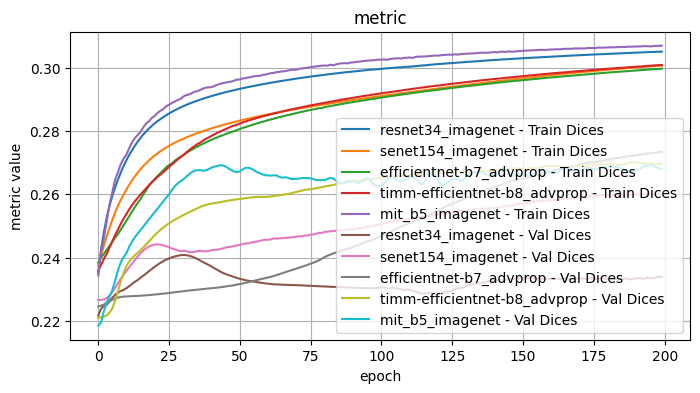

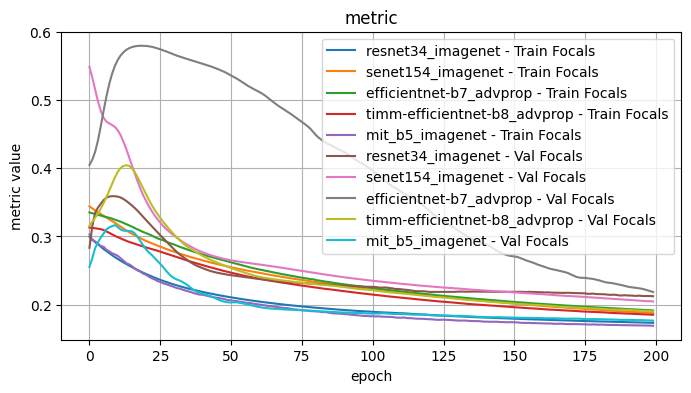

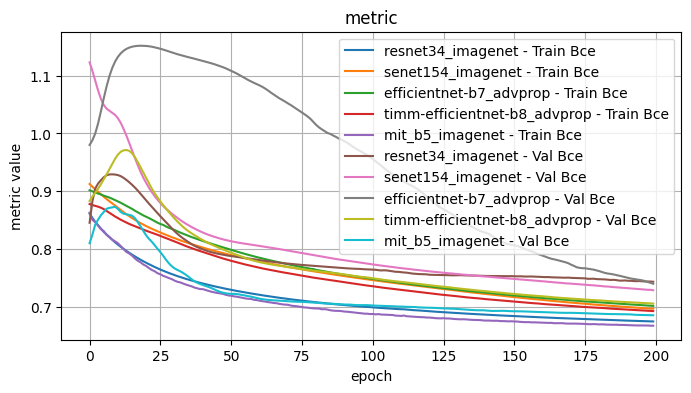

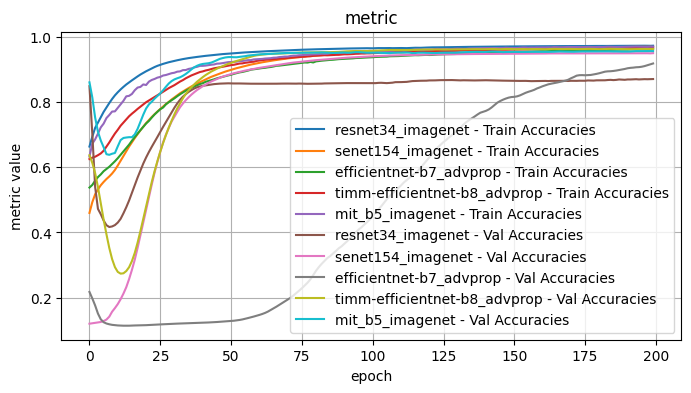

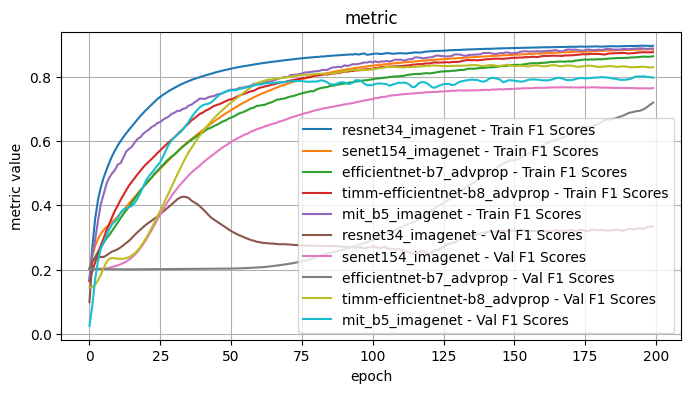

In [20]:
plot_selected(encoder_weight_results, ['resnet34_imagenet', 'senet154_imagenet', 'efficientnet-b7_advprop', 'timm-efficientnet-b8_advprop', 'mit_b5_imagenet'])

## Conclusions - Model Encoder and Weights

I tested the model encoder and encoder weight pairs with the following fixed choices: Architecture: Unet, Optimizer: Adam, LR: 1e-4, Loss Function: Dice Loss

From inspection, the best performing model encoder / weights pairs were:
- senet154 / imagenet - good results initially but surpassed with further training by other encoder/weight pairs
- efficientnet-b7 / advprop - a slower initial curve than the pair efficientnet-b7 / imagenet, but surpassed with enough epochs. Performed worse initially for accuracy and F1 scores.
- timm_efficientnet-b8 / advprop - some of the best results but with a curve that slows, possible with further epochs would be surpassed by efficientnet-b7 / advprop
- mit_b5 - performed well across the board, but surpassed at later epochs. Of particular note, the training and validation scores stayed consistently close.

Further observe:
- resnet34 / imagenet, resnet152 / imagenet, resnest101_32x8d / imagenet - The validation scores for multiple metrics decreases with further epochs, suggestive of overfitting

The two best performers appeared to be timm_ifficientnet-b8 / advprop and mit_b5 / imagenet. From the first pass, mit_b5 was the most consistent baseline, so I will use that to test the other model choices and perhaps revisit after further testing.

# Model Architecture



In [ ]:
# @title
model_architecture_results = {}

model_architectures = ['Unet', 'FPN', 'PSPNet', 'DeepLabV3', 'DeepLabV3Plus', 'MAnet', 'PAN', 'UPerNet', 'Segformer']
# incompatible with mit_b5: UnetPlusPlus, Linknet, DPT

for model_architecture in model_architectures:
        model, train_losses, train_dices, train_focals, train_bce, train_accuracies, train_f1_scores, val_losses, val_dices, val_focals, val_bce, val_accuracies, val_f1_scores = train_model(
            num_epochs=200,
            patience=0,
            model_name=model_architecture,
            encoder_name="mit_b5",
            encoder_weights="imagenet",
            optimizer_type="Adam",
            lr=1e-4,
            loss_function_type="DiceLoss"
        )
        model_architecture_results[model_architecture] = {
            'train_losses': train_losses,
            'train_dices': train_dices,
            'train_focals': train_focals,
            'train_bce': train_bce,
            'train_accuracies': train_accuracies,
            'train_f1_scores': train_f1_scores,
            'val_losses': val_losses,
            'val_dices': val_dices,
            'val_focals': val_focals,
            'val_bce': val_bce,
            'val_accuracies': val_accuracies,
            'val_f1_scores': val_f1_scores
        }

--------------------------------------------------
Training with Model Architecture: Unet, Encoder: mit_b5, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6965, Training Dice:   0.3035, Training Focals:   0.1772, Training BCE:   0.6804, Training Accuracy:   0.9685, Training F1:   0.8838
Validation Loss: 0.7312, Validation Dice: 0.2688, Validation Focals: 0.1898, Validation BCE: 0.7037, Validation Accuracy: 0.9485, Validation F1: 0.7799
--------------------------------------------------
Training with Model Architecture: FPN, Encoder: mit_b5, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6890, Training Dice:   0.3110, Training Focals:   0.1586, Training BCE:   0.6490, Training Accuracy:   0.9656, Training F1:   0.8756
Validation Loss: 0.7136, Validation Dice: 0.2864, Validation Focals: 0.1699, Validation BCE: 0.6663, Validation Accuracy: 0.9496, Validation F1: 0.8015

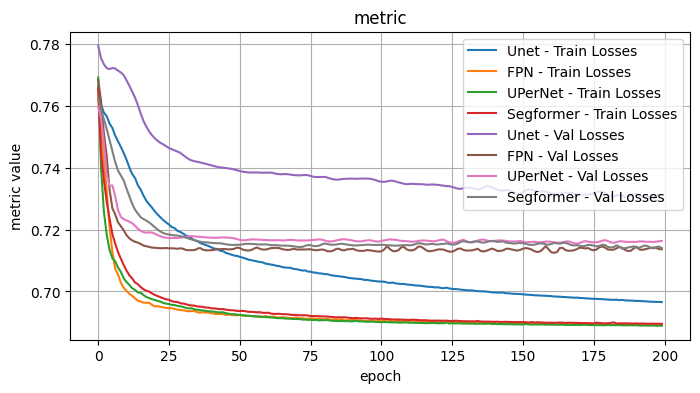

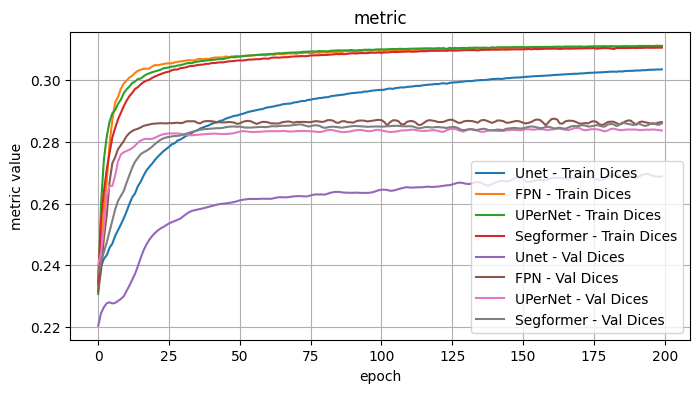

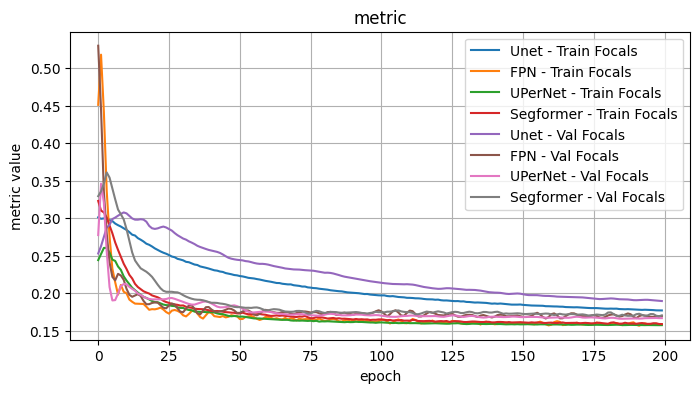

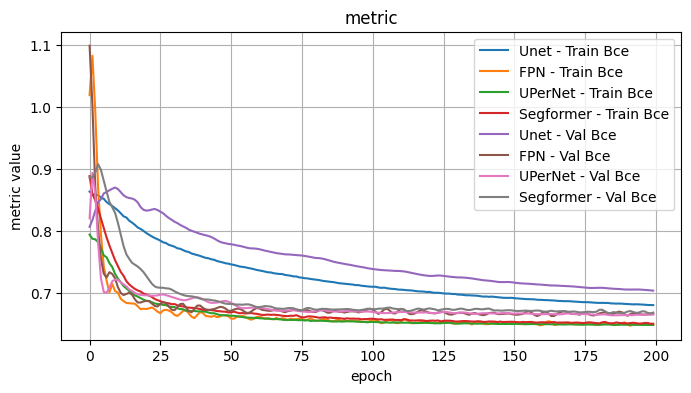

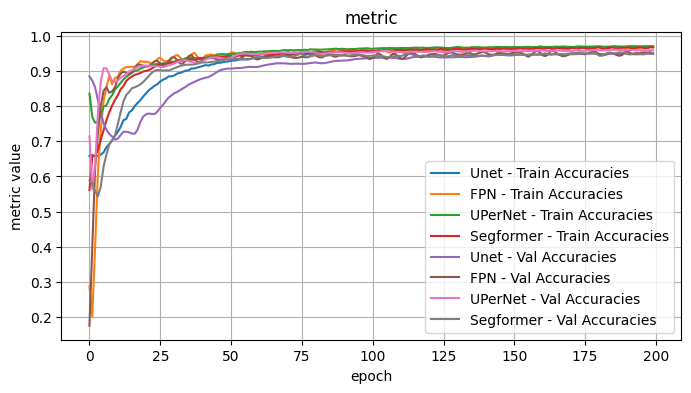

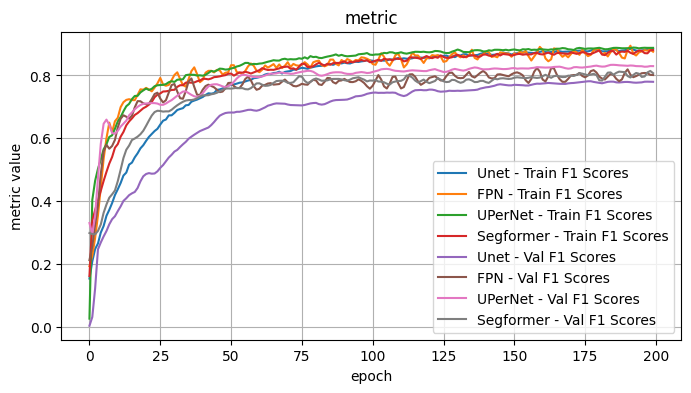

In [21]:
plot_selected(model_architecture_results, ['Unet', 'FPN', 'UPerNet', 'Segformer'])

## Conclusion - Model Architecture

I tested the model architecture with the following fixed choices: Model encoder / weights: mit_b5 / imagenet, Optimizer: Adam, LR: 1e-4, Loss Function: Dice Loss

I observe:
- The best performers were FPN (although a bit noisy), UPerNet, Segformer
- DeepLabV3 outperformed DeepLabV3Plus slightly.

Overall best appears to be UPerNet. In particular, for the given choices the curves were generally smoother with less variance.


# Optimizers

In [ ]:
# @title
optimizer_results = {}

optimizers = ['Adadelta', 'Adafactor', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'ASGD', 'NAdam', 'RAdam', 'RMSprop', 'Rprop', 'SGD']

for optimizer_type in optimizers:
        model, train_losses, train_dices, train_focals, train_bce, train_accuracies, train_f1_scores, val_losses, val_dices, val_focals, val_bce, val_accuracies, val_f1_scores = train_model(
            num_epochs=200,
            patience=0,
            model_name="UPerNet",
            encoder_name="mit_b5",
            encoder_weights="imagenet",
            optimizer_type=optimizer_type,
            lr=1e-4,
            loss_function_type="DiceLoss"
        )
        optimizer_results[optimizer_type] = {
            'train_losses': train_losses,
            'train_dices': train_dices,
            'train_focals': train_focals,
            'train_bce': train_bce,
            'train_accuracies': train_accuracies,
            'train_f1_scores': train_f1_scores,
            'val_losses': val_losses,
            'val_dices': val_dices,
            'val_focals': val_focals,
            'val_bce': val_bce,
            'val_accuracies': val_accuracies,
            'val_f1_scores': val_f1_scores
        }

--------------------------------------------------
Training with Model Architecture: UPerNet, Encoder: mit_b5, Weight: imagenet, Optimizer: Adadelta, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.7602, Training Dice:   0.2398, Training Focals:   0.4987, Training BCE:   1.0725, Training Accuracy:   0.1249, Training F1:   0.2122
Validation Loss: 0.7746, Validation Dice: 0.2254, Validation Focals: 0.5135, Validation BCE: 1.0898, Validation Accuracy: 0.1152, Validation F1: 0.2010
--------------------------------------------------
Training with Model Architecture: UPerNet, Encoder: mit_b5, Weight: imagenet, Optimizer: Adafactor, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6950, Training Dice:   0.3050, Training Focals:   0.1773, Training BCE:   0.6750, Training Accuracy:   0.9377, Training F1:   0.7950
Validation Loss: 0.7202, Validation Dice: 0.2798, Validation Focals: 0.1865, Validation BCE: 0.6905, Validation Accuracy: 0.9235, Valid

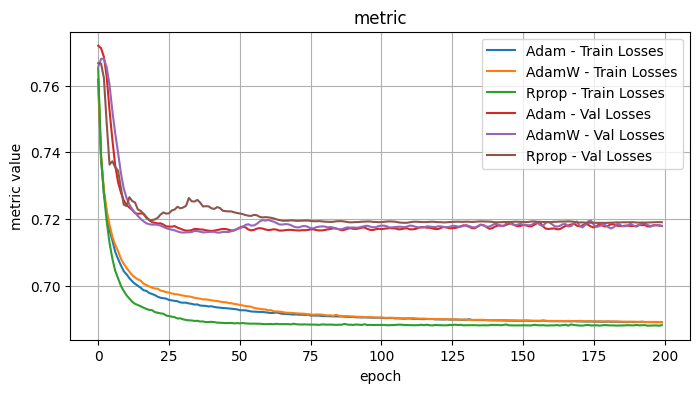

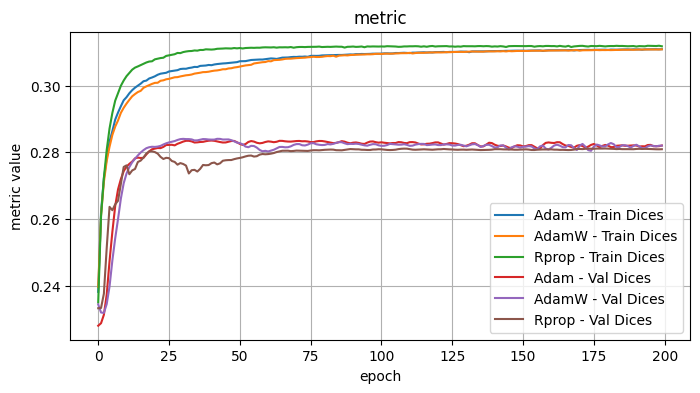

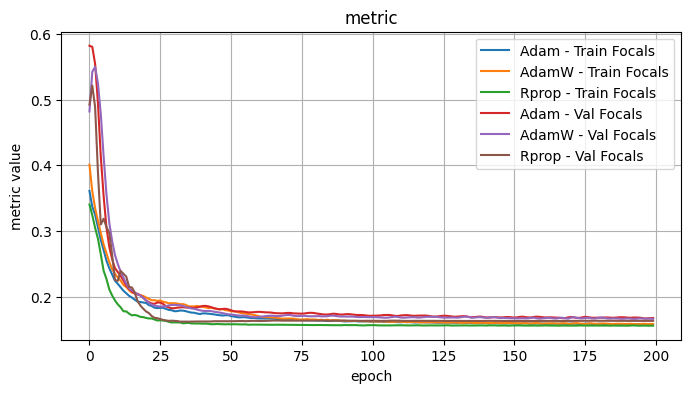

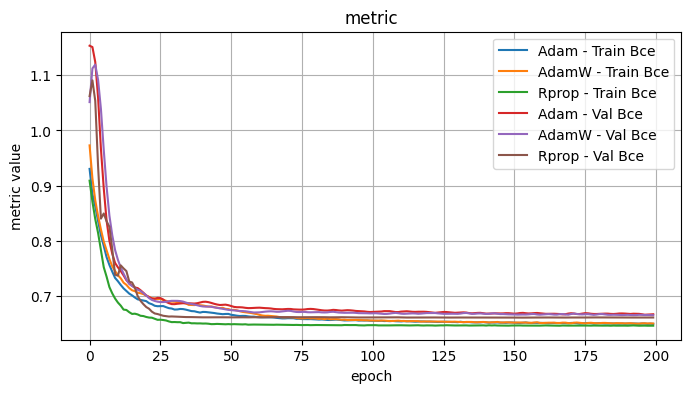

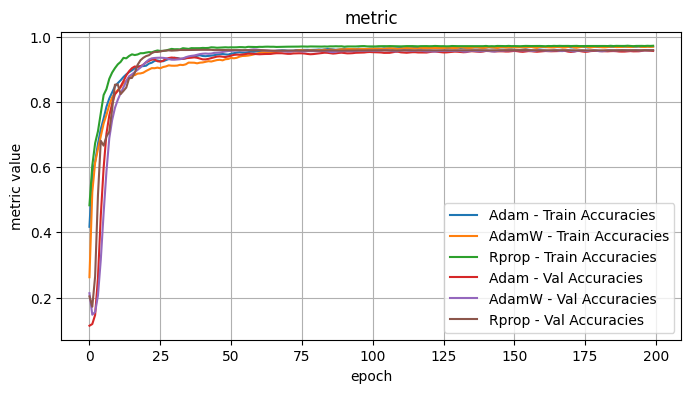

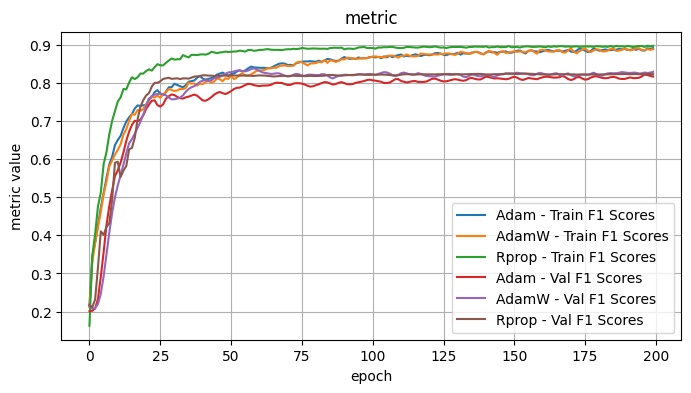

In [22]:
plot_selected(optimizer_results, ['Adam', 'AdamW', 'Rprop'])

## Conclusions - Optimizers

I tested the optimizers with the following fixed choices: Model Architecture: UPerNet, Model encoder / weights: mit_b5 / imagenet, LR: 1e-4, Loss Function: Dice Loss

Observe:
- Adadelta, ASGD, SGD - the validation curves showed minimal improvement and were noisy. I would suspect further hyperparameter tweaks would be necessary for these optimizers.
- Adam, AdamW - Quite comparable curves and performance, with the edge to Adam.

The best optimizers appeared to be Adam and Rprop.

# Loss functions

In [ ]:
# @title
loss_results = {}

loss_functions = ['FocalLoss', 'DiceLoss', 'SoftBCEWithLogitsLoss', 'IOULoss', 'TverskyLoss', 'LovaszLoss', 'CombinedLoss']

for loss_function in loss_functions:
    model, train_losses, train_dices, train_focals, train_bce, train_accuracies, train_f1_scores, val_losses, val_dices, val_focals, val_bce, val_accuracies, val_f1_scores = train_model(
        num_epochs=200,
        patience=0,
        model_name="UPerNet",
        encoder_name="mit_b5",
        encoder_weights="imagenet",
        optimizer_type="Adam",
        lr=1e-4,
        loss_function_type=loss_function
    )
    loss_results[loss_function] = {
        'train_losses': train_losses,
        'train_dices': train_dices,
        'train_focals': train_focals,
        'train_bce': train_bce,
        'train_accuracies': train_accuracies,
        'train_f1_scores': train_f1_scores,
        'val_losses': val_losses,
        'val_dices': val_dices,
        'val_focals': val_focals,
        'val_bce': val_bce,
        'val_accuracies': val_accuracies,
        'val_f1_scores': val_f1_scores
    }

--------------------------------------------------
Training with Model Architecture: UPerNet, Encoder: mit_b5, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: FocalLoss
Finished Training
Training Loss:   0.1556, Training Dice:   0.3060, Training Focals:   0.1556, Training BCE:   0.6476, Training Accuracy:   0.9828, Training F1:   0.9304
Validation Loss: 0.1628, Validation Dice: 0.2741, Validation Focals: 0.1628, Validation BCE: 0.6631, Validation Accuracy: 0.9625, Validation F1: 0.8253
--------------------------------------------------
Training with Model Architecture: UPerNet, Encoder: mit_b5, Weight: imagenet, Optimizer: Adam, LR: 0.0001, Loss Function: DiceLoss
Finished Training
Training Loss:   0.6891, Training Dice:   0.3109, Training Focals:   0.1580, Training BCE:   0.6490, Training Accuracy:   0.9698, Training F1:   0.8899
Validation Loss: 0.7155, Validation Dice: 0.2845, Validation Focals: 0.1680, Validation BCE: 0.6656, Validation Accuracy: 0.9567, Validation F1

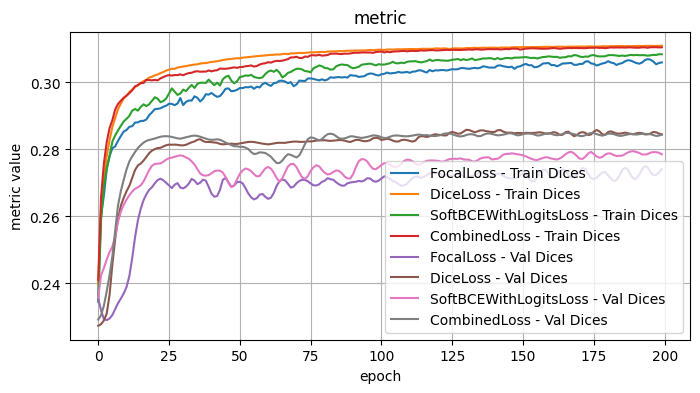

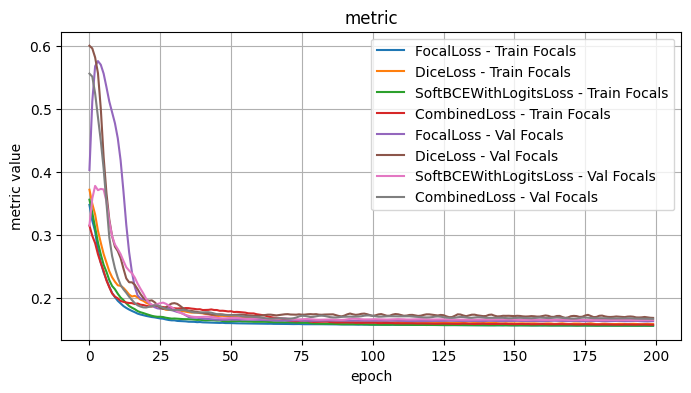

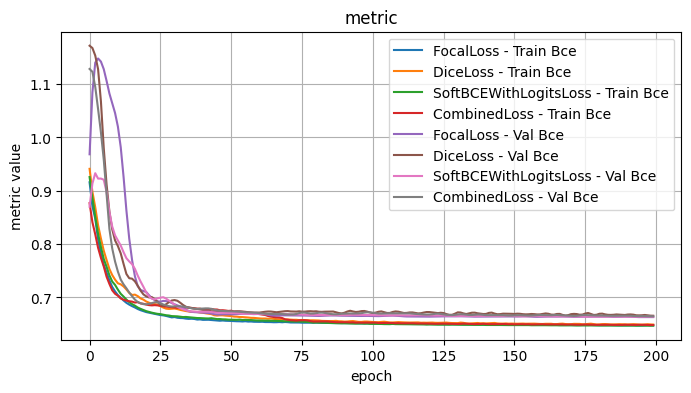

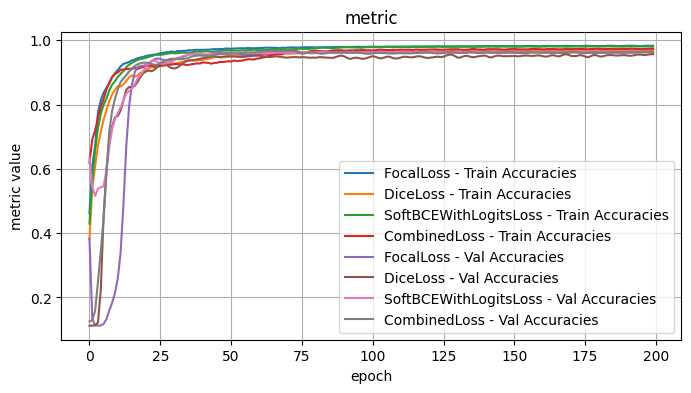

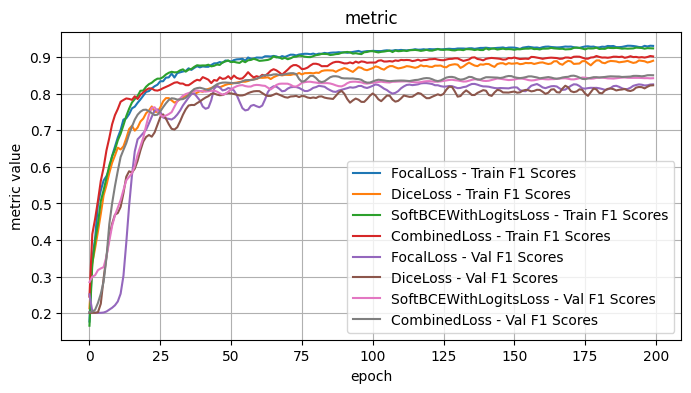

In [23]:
plot_selected(loss_results, ['FocalLoss', 'DiceLoss', 'SoftBCEWithLogitsLoss', 'CombinedLoss'], plot_loss=False)

## Conclusions - Loss Functions

I tested the model architecture with the following fixed choices: Model encoder / weights: mit_b5 / imagenet, Model Architecture: UPerNet, Optimizer: Adam, LR: 1e-4, Loss Function: Dice Loss

The loss functions generally yielded similar results, without much differentiaton. This may in part be due to the fact that the other optimizations have made it hard to distinguish differences at this scale.

As it stands, I think that the combined loss function is a very reasonable choice, given that its successful usage in image segmentation tasks.

# Results:

- Model Encoder and Encoder Weights: mit_b5 / imagenet
- Model Architecture: UPerNet
- Optimizer: Adam
- Learning Rate: 1e-4
- Loss Function: Combined Loss (Focal + LogDice)
